
Step 1: Loading CSV files with sampling...
Found 169 CSV files.
Data loaded. Shape after sampling and cleaning: (4668657, 47)
Unique classes: 34 -> ['DoS-SYN_Flood' 'DDoS-UDP_Flood' 'DDoS-TCP_Flood'
 'DDoS-SynonymousIP_Flood' 'DDoS-ICMP_Flood' 'DDoS-SYN_Flood'
 'DDoS-RSTFINFlood' 'DDoS-PSHACK_Flood' 'Mirai-greip_flood'
 'DDoS-ACK_Fragmentation' 'DNS_Spoofing' 'DoS-TCP_Flood' 'DoS-UDP_Flood'
 'BenignTraffic' 'Mirai-udpplain' 'Mirai-greeth_flood' 'Recon-PortScan'
 'DoS-HTTP_Flood' 'DDoS-UDP_Fragmentation' 'Recon-HostDiscovery'
 'Recon-OSScan' 'VulnerabilityScan' 'MITM-ArpSpoofing' 'DDoS-SlowLoris'
 'DDoS-ICMP_Fragmentation' 'DDoS-HTTP_Flood' 'DictionaryBruteForce'
 'BrowserHijacking' 'Recon-PingSweep' 'SqlInjection' 'XSS'
 'CommandInjection' 'Backdoor_Malware' 'Uploading_Attack']
Training Random Forest model for 34-class classification...

=== 34-Class Random Forest Evaluation ===
Accuracy : 0.9944748600240755
Recall   : 0.7547870649183007
Precision: 0.91668494769804
F1-score : 0.780310

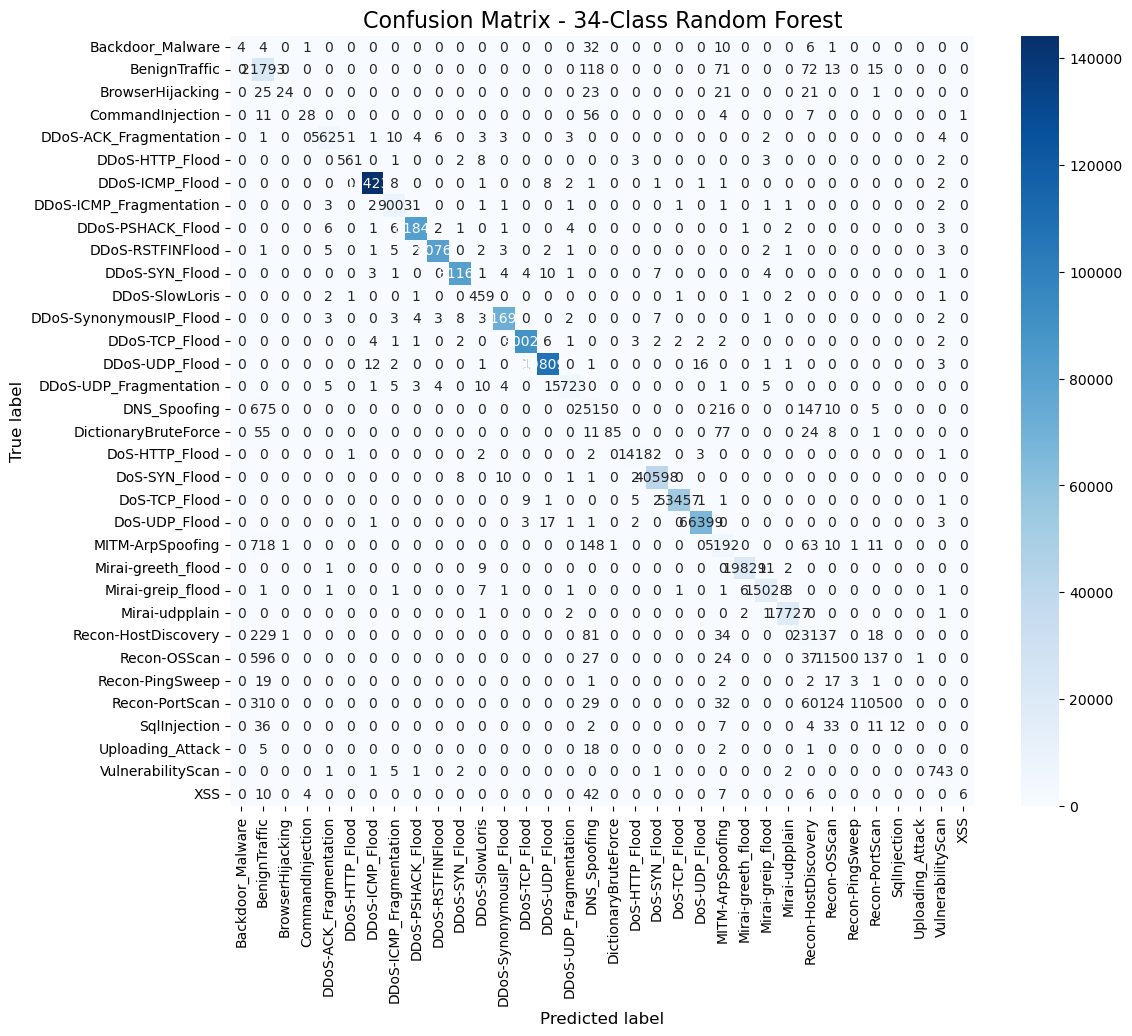


Top 20 important features:
1. IAT: 0.2564
2. Magnitue: 0.0542
3. syn_count: 0.0531
4. AVG: 0.0464
5. Protocol Type: 0.0422
6. Min: 0.0415
7. Tot size: 0.0413
8. Tot sum: 0.0361
9. syn_flag_number: 0.0356
10. Max: 0.0355
11. Header_Length: 0.0350
12. psh_flag_number: 0.0312
13. ack_count: 0.0303
14. flow_duration: 0.0252
15. fin_flag_number: 0.0243
16. fin_count: 0.0235
17. rst_count: 0.0233
18. Rate: 0.0203
19. urg_count: 0.0182
20. ack_flag_number: 0.0180


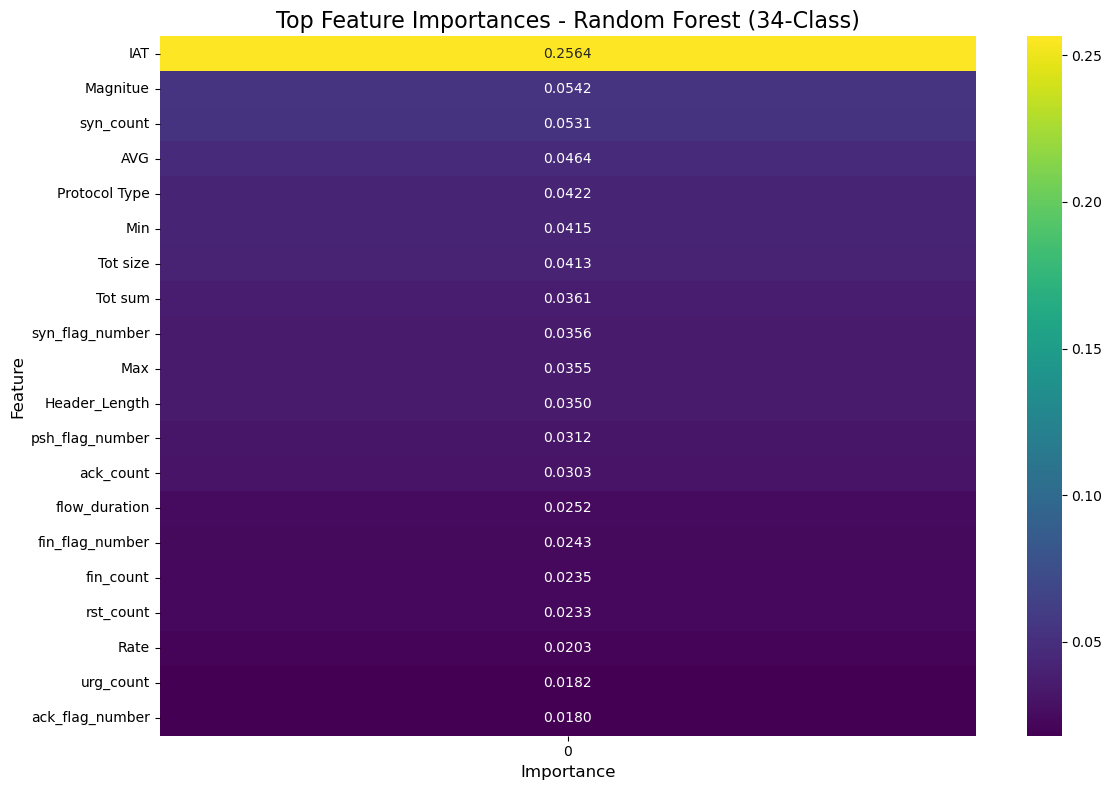



34-Class Classification Analysis Complete.


In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42                      
DATASET_PATH = '/Users/bodapati/Downloads/wataiData 3/csv/CICIoT2023'  
SAMPLING_FRACTION = 0.1                 
TOP_N_FEATURES = 20                      


def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title, fontsize=16)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.show()

# STEP 1: Load and sample CSV files
print("\nStep 1: Loading CSV files with sampling...")
all_files = glob.glob(os.path.join(DATASET_PATH, "*.csv"))  # List all CSV files
if not all_files:
    raise FileNotFoundError(f"No CSV files found in {DATASET_PATH}")
print(f"Found {len(all_files)} CSV files.")

df_list = []
for file in all_files:
    df = pd.read_csv(file).sample(frac=SAMPLING_FRACTION, random_state=RANDOM_STATE)  # Sample rows
    df_list.append(df)

main_df = pd.concat(df_list, ignore_index=True)  # Combine all sampled CSVs
main_df.dropna(axis=1, how='all', inplace=True)  # Drop empty columns
main_df.dropna(inplace=True)                      # Drop rows with missing values
main_df.drop_duplicates(inplace=True)            # Drop duplicate rows
print(f"Data loaded. Shape after sampling and cleaning: {main_df.shape}")

# STEP 2: 34-class labels
main_df.dropna(subset=['label'], inplace=True)  # Remove rows with missing labels
y = main_df['label']                            # Target labels
print(f"Unique classes: {y.nunique()} -> {y.unique()}")  # Check number of classes

# STEP 3: Feature preparation
cols_to_drop = ['label', 'ts']  # Columns to exclude from features
existing_cols_to_drop = [col for col in cols_to_drop if col in main_df.columns]

X = main_df.drop(columns=existing_cols_to_drop).select_dtypes(include=np.number)  # Keep only numeric features
y = main_df['label']  # Target column

le = LabelEncoder()          # Convert class labels to integers
y_encoded = le.fit_transform(y)

# STEP 4: Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RANDOM_STATE, stratify=y_encoded
)  

scaler = StandardScaler()           
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# STEP 5: Train Random Forest model
print("Training Random Forest model for 34-class classification...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# STEP 6: Model evaluation
y_pred = rf_model.predict(X_test_scaled)

print("\n=== 34-Class Random Forest Evaluation ===")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred, average='macro', zero_division=0))
print("Precision:", precision_score(y_test, y_pred, average='macro', zero_division=0))
print("F1-score :", f1_score(y_test, y_pred, average='macro', zero_division=0))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# STEP 7: Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=le.classes_, title='Confusion Matrix - 34-Class Random Forest')

# STEP 8: Feature importance
importances = rf_model.feature_importances_     
indices = np.argsort(importances)[::-1]         
feature_names = X.columns

print("\nTop 20 important features:")
for i in range(min(TOP_N_FEATURES, len(feature_names))):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

# STEP 9: Feature importance heatmap
importance_df = pd.DataFrame([importances], columns=feature_names)
top_features = importance_df.T.sort_values(by=0, ascending=False).head(TOP_N_FEATURES)
plt.figure(figsize=(12, 8))
sns.heatmap(top_features, annot=True, cmap='viridis', fmt=".4f")
plt.title("Top Feature Importances - Random Forest (34-Class)", fontsize=16)
plt.ylabel("Feature", fontsize=12)
plt.xlabel("Importance", fontsize=12)
plt.tight_layout()
plt.show()

print("\n\n34-Class Classification Analysis Complete.")